In [1]:
pip install phiflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.1/191.1 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.2/316.2 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phiflow: filename=phiflow-3.2.0-py3-none-any.whl size=219836 sha256=58ef2498d3c777147658f591e720f0ff9ca1529e8d3b8ee35c70131f2e90031e
  Stored in directory: /root/.cache/pip/wheels/87/3f/e0/3fc3444a47e1aa7a62a181ae5d5aa6a96f0dadddf015f4897c
  Created wheel for phiml: filename=phiml-1.10.2-py3-none-any.whl size=326853 sha256=a8e85045a02373500c3c2dadd53e657b02a23f7a4ff6102e136b7fb411a09b6b
  Stored in directory: /root/.cache/pip/wheels/e8/62/98/b21e4d419024451eae7fbee1d34b7ef6653b544dd87391680e
Successfully built phiflow phiml


/usr/local/lib/python3.10/dist-packages/phi/vis/_matplotlib/_matplotlib_plots.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # because subplot titles can be added after figure creation


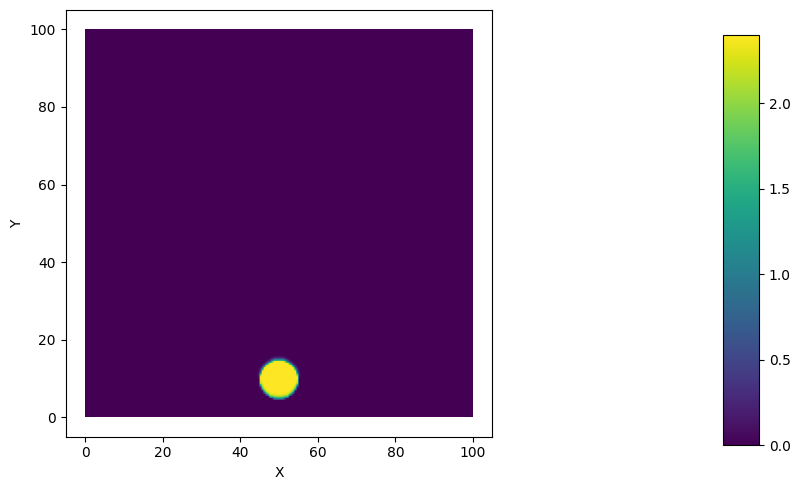

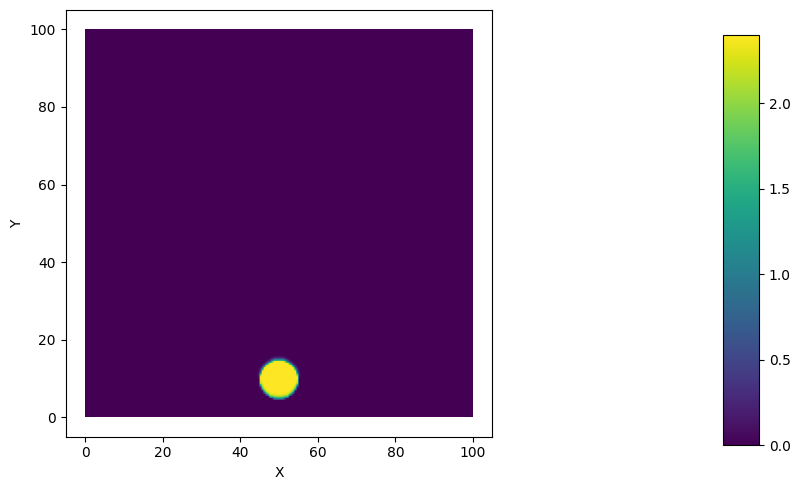

In [20]:
import matplotlib.pyplot as plt
from phi.jax.flow import *
from phi.flow import *
domain = Box(x=100, y=100)
inflow = Sphere(x=50, y=9.5, radius=5)
inflow_rate = 0.2

@jit_compile
def step(v, s, p, dt):
    s = advect.mac_cormack(s, v, dt) + inflow_rate * resample(inflow, to=s, soft=True)
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, (), Solve('CG', 1e-3, x0=p))
    return v, s, p

v0 = StaggeredGrid(0, 0, domain, x=64, y=64)
smoke0 = CenteredGrid(0, ZERO_GRADIENT, domain, x=200, y=200)
v_trj, s_trj, p_trj = iterate(step, batch(time=19), v0, smoke0, None, dt=.5, substeps=3)
plot(s_trj.time[4])



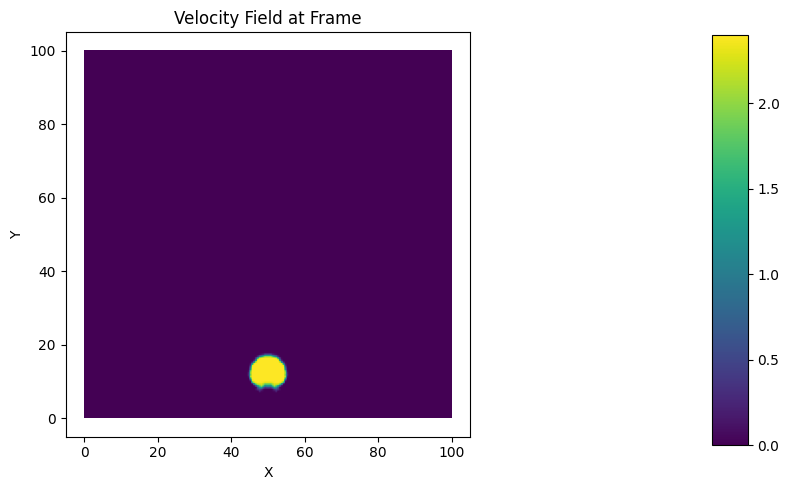

In [23]:
def combined_estimation(Φ_prev, u_prev):
    dt=10
    # 第1步：预测无散度速度场
    u_hat = Divergence_free(advect.semi_lagrangian(u_prev, u_prev, dt))   # type: ignore
    # 第2步：预测密度场
    Φ_tilde = advect.mac_cormack(Φ_prev, u_hat,dt)
    plot(Φ_tilde, title=f"Velocity Field at Frame")

def Divergence_free(u):
    p = None  # 给 press 赋一个初值，可以是 None 或者其他合理值
    u_div_free, p = fluid.make_incompressible(u, (), Solve('CG', 1e-3, x0=p))
    return u_div_free  # 返回无散度的速度场


combined_estimation(s_trj.time[4], v_trj.time[4])